In [ ]:
import tensorflow as tf
import warnings
# Disabling Future Warnings0
warnings.filterwarnings(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential
from keras.models import load_model as load
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
import numpy as np

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
fake = np.load('/content/drive/MyDrive/Hacktrick/Footprints Datasets/fake.npz')
real = np.load('/content/drive/MyDrive/Hacktrick/Footprints Datasets/real.npz')

In [ ]:
!pip install pydub

In [ ]:
fake_data = fake['x']
fake_labels = np.zeros(len(fake_data))
real_data = real['x']
real_labels = np.ones(len(real_data))

In [ ]:
Tx = 1998 
n_freq = 101

In [ ]:
print("fake len: " + str(len(fake_data[0])))    
print("real len: " + str(len(real_data[0])))   
# print("activate[1] len: " + str(len(activates[1])))     

fake len: 1998
real len: 1998


In [ ]:
# x = fake_data + real_data
# y = fake_labels + real_labels

x = np.concatenate((fake_data, real_data), axis=0).astype(np.float64)
y = np.concatenate((fake_labels, real_labels), axis=0)
y = y.reshape(-1, 1)

In [ ]:
clip_min = -1e10
clip_max = 1e10
x = np.clip(x, clip_min, clip_max)

In [ ]:
print(x.shape)
print(y.shape)

(1512, 1998, 101)
(1512, 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
mean = np.mean(X_train, axis=(0, 1)) 
std = np.std(X_train, axis=(0, 1))   

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

In [ ]:
def eagle_model(input_shape):

  X_input = Input(shape=input_shape)

  X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = Dropout(rate=0.8)(X)

  X = GRU(128, return_sequences=True)(X)
  X = Dropout(rate=0.8)(X)
  X = BatchNormalization()(X)

  X = GRU(128, return_sequences=True)(X)
  X = Dropout(rate=0.8)(X)
  X = BatchNormalization()(X)
  X = Dropout(rate=0.8)(X)

  X = GlobalAveragePooling1D()(X)

  X = Dense(1, activation='sigmoid')(X)


  model = Model(inputs=X_input, outputs=X)

  return model

In [ ]:
model = eagle_model(input_shape = (Tx, n_freq))


In [ ]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1998, 101)]       0         
                                                                 
 conv1d (Conv1D)             (None, 496, 196)          297136    
                                                                 
 batch_normalization (Batch  (None, 496, 196)          784       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 496, 196)          0         
                                                                 
 dropout (Dropout)           (None, 496, 196)          0         
                                                                 
 gru (GRU)                   (None, 496, 128)          125184    
                                                             

In [ ]:
from tensorflow.keras.metrics import BinaryAccuracy

opt = Adam(lr=1e-8, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[BinaryAccuracy()])

In [ ]:
model.fit(X_train, y_train, batch_size = 1, epochs=6)

Epoch 1/6
1209/1209 [==============================] - 51s 42ms/step - loss: 0.6997 - binary_accuracy: 0.5087
Epoch 2/6
1209/1209 [==============================] - 47s 39ms/step - loss: 0.6964 - binary_accuracy: 0.5037
Epoch 3/6
1209/1209 [==============================] - 44s 37ms/step - loss: 0.6998 - binary_accuracy: 0.4979
Epoch 4/6
1209/1209 [==============================] - 46s 38ms/step - loss: 0.7030 - binary_accuracy: 0.4806
Epoch 5/6
1209/1209 [==============================] - 45s 37ms/step - loss: 0.7005 - binary_accuracy: 0.4665
Epoch 6/6
1209/1209 [==============================] - 45s 37ms/step - loss: 0.6989 - binary_accuracy: 0.4897


In [ ]:
loss, acc, = model.evaluate(X_test, y_test)
print("Dev set accuracy = ", acc)

10/10 [==============================] - 0s 30ms/step - loss: 0.6910 - binary_accuracy: 0.5248
Dev set accuracy =  0.5247524976730347


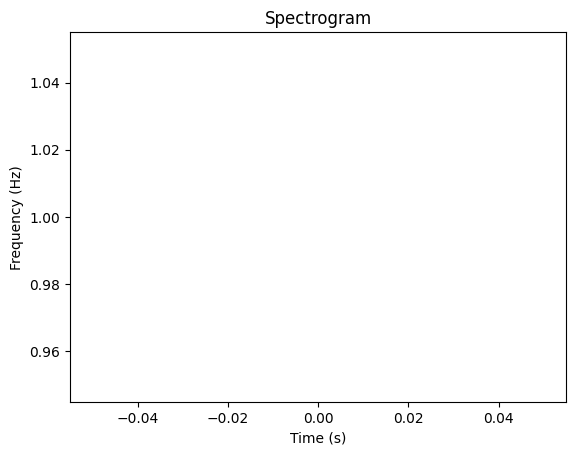

In [ ]:
import matplotlib.pyplot as plt

plt.plot((real_labels[33]).astype(np.uint8).T)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.show()

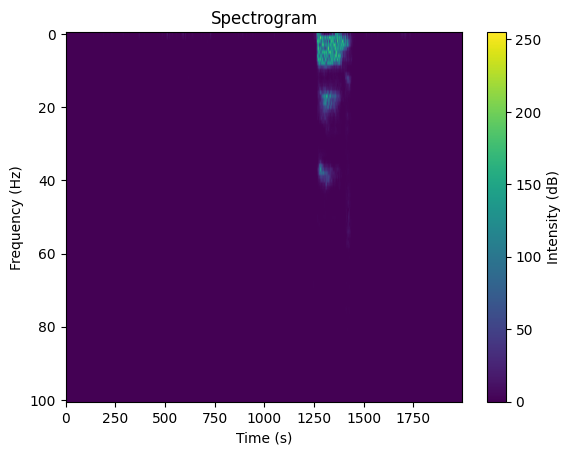

In [ ]:
import matplotlib.pyplot as plt

plt.imshow((fake_data[30]).astype(np.uint8).T, aspect='auto')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.colorbar(label='Intensity (dB)')
plt.show()

In [ ]:
def eagle_solve(x):
  spect = np.expand_dims(x, axis=0)
  prediction = model.predict(spect)
  return 1 if prediction > 0.4 else 0

In [ ]:
count_miss = 0
count_1 = 0
count_0 = 0
for i,x in enumerate(X_test):
  t1 = eagle_solve(x)
  t2 = int(y_test[i][0])
  if t1 != t2:
    count_1 += 1 if t2 == 1 else 0
    count_0 += 1 if t2 == 0 else 0
    count_miss+=1

In [ ]:
print(count_miss)
print(count_1)
print(count_0)

148
0
148


In [ ]:
# model.save("/content/drive/MyDrive/Hacktrick/models/17_best_hany_with_foot.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
